#Install required packages

In [22]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.1.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#GNN to classify breast cancer patients in LUMINAL A / LUMINAL B

##Preprocessing

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

from scipy.stats import pearsonr
from sklearn import preprocessing

In [24]:
df = pd.read_csv("/content/drive/MyDrive/AI for bioinformatics/LAB/LAB 2/dataset_LUMINAL_A_B.csv")
df

,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,Luminal A,2356.253792,26808.891103,57790.161586,0.0,71389.111749,381288.489078,0.0,1677.413295,1.969141e+06,...,113036.499486,0.0,20911.752405,13957.784680,1.047700e+06,0.0,1937.768563,10731.974977,0.0,0.000000
1,Luminal A,0.000000,231.960840,115769.964478,0.0,77938.573803,238017.846096,0.0,0.000000,4.865670e+06,...,850405.301444,0.0,0.000000,2122.068451,0.000000e+00,0.0,5499.352680,2479.070667,0.0,0.000000
2,Luminal A,0.000000,315.873536,44954.933833,0.0,58546.997851,249302.406604,0.0,270.107768,2.519212e+06,...,301948.579552,0.0,0.000000,481.622432,0.000000e+00,0.0,312.031830,4822.690978,0.0,0.000000
3,Luminal A,1074.333108,0.000000,86991.783442,0.0,36082.381881,176274.146728,0.0,101.975469,2.855010e+06,...,293581.147891,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,12631.387770,0.0,0.000000
4,Luminal A,1395.887715,0.000000,65199.337535,0.0,91469.201926,263704.398926,0.0,66.248682,4.235429e+06,...,350449.557585,0.0,0.000000,1181.263740,0.000000e+00,0.0,0.000000,1626.418477,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Luminal B,1145.198255,0.000000,80441.669167,0.0,88490.526118,158523.967323,0.0,27.175493,1.086328e+06,...,413667.046455,0.0,10163.634516,484.559452,0.000000e+00,0.0,0.000000,2486.701567,0.0,727.272595
96,Luminal B,0.000000,0.000000,64247.731360,0.0,44968.186413,207751.035002,0.0,908.682002,1.637001e+06,...,511495.838599,0.0,0.000000,578.660087,0.000000e+00,0.0,0.000000,1158.874086,0.0,0.000000
97,Luminal B,1584.531801,0.000000,111015.831651,0.0,106435.669012,436192.769576,0.0,12483.483824,3.462098e+06,...,482271.048999,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,6042.165123,0.0,1006.276904
98,Luminal B,0.000000,178.431416,34013.611358,0.0,35639.417589,217396.623013,0.0,0.000000,8.757449e+06,...,141814.187314,0.0,0.000000,362.746744,7.685468e+03,0.0,117.507536,1044.297168,0.0,544.444576


In [25]:
df = df.sample(frac=1) # Shuffling of dataset rows
df

,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
21,Luminal A,915.172647,317.457778,41755.769022,0.0,87481.786271,190569.343133,0.0,347.471968,2.750029e+06,...,2.295993e+05,0.0,0.000000,387.230381,1640.839847,0.0,188.158083,7173.380709,0.000000,0.000000
88,Luminal B,478.576522,0.000000,77848.609656,0.0,102734.848886,164791.822003,0.0,90.852762,2.737085e+06,...,2.590086e+05,0.0,0.000000,0.000000,0.000000,0.0,131.192792,35028.260101,0.000000,0.000000
93,Luminal B,627.092923,0.000000,161266.573646,0.0,42122.887486,216560.890346,0.0,386.902920,3.405488e+06,...,4.675201e+05,0.0,0.000000,1592.023749,0.000000,0.0,0.000000,15343.802811,0.000000,0.000000
82,Luminal B,0.000000,64.759178,72132.693350,0.0,81007.090231,205849.196729,0.0,132.903494,7.545887e+06,...,1.425334e+06,0.0,0.000000,394.961515,0.000000,0.0,191.914698,197.745912,0.000000,1185.591096
10,Luminal A,0.000000,56.020355,52350.971837,0.0,115781.398083,219550.253711,0.0,479.037694,2.970200e+06,...,2.616921e+05,0.0,3583.201949,1366.656286,0.000000,0.0,221.356105,7740.528752,499.400969,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Luminal A,0.000000,0.000000,49410.433167,0.0,76185.343543,406905.112244,0.0,139.320719,1.983987e+06,...,2.719176e+05,0.0,0.000000,828.064343,12280.863345,0.0,67.060423,4197.704361,0.000000,1242.837180
19,Luminal A,0.000000,84.454195,85179.081335,0.0,59612.118100,279448.189084,0.0,173.323042,3.432120e+06,...,5.433264e+05,0.0,0.000000,515.079997,2182.586452,0.0,0.000000,2127.557792,0.000000,1546.161422
89,Luminal B,379.969166,52.721928,30013.414043,0.0,104234.478851,219015.972437,0.0,198.366256,3.898408e+06,...,3.787425e+05,0.0,3372.226344,1286.188832,8175.094167,0.0,0.000000,1529.399983,0.000000,0.000000
41,Luminal A,0.000000,149.280632,124756.861755,0.0,62792.406756,243331.413539,0.0,127.651904,2.846792e+06,...,2.477413e+05,0.0,0.000000,455.225862,1928.962112,0.0,294.930114,10028.415887,0.000000,0.000000


In [26]:
y = df.l

# Alway remember to scale your data!
X = df.drop(labels=['l'], axis=1)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Luminal_A = 0, Luminal_B = 1
y = preprocessing.LabelEncoder().fit_transform(y)
X

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,0.424534,-0.061633,-0.780908,-0.100504,0.413131,-0.601938,-0.151001,-0.237077,-0.598381,0.020471,...,-0.611178,-0.100504,-0.154881,-0.355523,-0.156843,-0.113304,-0.112917,-0.210333,-0.202412,-0.659515
1,-0.028030,-0.172013,0.005234,-0.100504,1.013269,-0.920220,-0.151001,-0.312153,-0.605004,-0.364988,...,-0.481106,-0.100504,-0.154881,-0.531912,-0.158421,-0.113304,-0.120144,0.182714,-0.202412,-0.659515
2,0.125918,-0.172013,1.822168,-0.100504,-1.371534,-0.281013,-0.151001,-0.225541,-0.262969,-0.446362,...,0.441099,-0.100504,-0.154881,0.193280,-0.158421,-0.113304,-0.136790,-0.095044,-0.202412,-0.659515
3,-0.524110,-0.149496,-0.119265,-0.100504,0.158381,-0.413273,-0.151001,-0.299851,1.855754,-0.208285,...,4.677320,-0.100504,-0.154881,-0.352001,-0.158421,-0.113304,-0.112440,-0.308763,-0.202412,0.518810
4,-0.524110,-0.152535,-0.550133,-0.100504,1.526591,-0.244103,-0.151001,-0.198587,-0.485715,-0.068787,...,-0.469238,-0.100504,0.125929,0.090621,-0.158421,-0.113304,-0.108704,-0.202330,4.380944,-0.659515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.524110,-0.172013,-0.614181,-0.100504,-0.031332,2.069218,-0.151001,-0.297973,-0.990379,-0.238385,...,-0.424012,-0.100504,-0.154881,-0.154716,-0.146605,-0.113304,-0.128281,-0.252321,-0.202412,0.575705
96,-0.524110,-0.142648,0.164900,-0.100504,-0.683413,0.495473,-0.151001,-0.288026,-0.249341,0.071109,...,0.776375,-0.100504,-0.154881,-0.297285,-0.156321,-0.113304,-0.136790,-0.281532,-0.202412,0.877170
97,-0.130244,-0.153682,-1.036669,-0.100504,1.072273,-0.250700,-0.151001,-0.280699,-0.010732,-0.349450,...,0.048453,-0.100504,0.109395,0.053967,-0.150555,-0.113304,-0.136790,-0.289972,-0.202412,-0.659515
98,-0.524110,-0.120108,1.026947,-0.100504,-0.558283,0.049529,-0.151001,-0.301387,-0.548865,0.285380,...,-0.530939,-0.100504,-0.154881,-0.324550,-0.156565,-0.113304,-0.099369,-0.170047,-0.202412,-0.659515


## GNN

###Computing edges with Pearson Correlation Coefficient

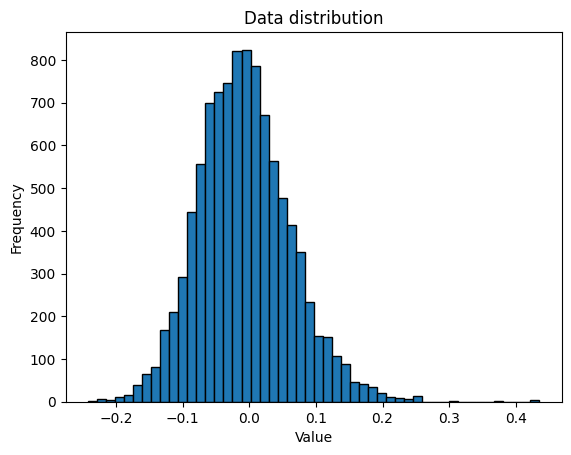

In [27]:
corr_list = []

for i in range(X.shape[0]):
  for j in range(X.shape[0]):
    if i != j:
      corr, _ = pearsonr(X.iloc[i], X.iloc[j])
      corr_list.append([i, j, corr])

# Create an histogram
plt.hist([corr[2] for corr in corr_list], bins=50, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data distribution')

plt.show()

In [28]:
threshold = 0
corr_list_copy = corr_list.copy()

# Remove data with correlation negative
for value in corr_list.copy():
  if value[2] < threshold:
    corr_list_copy.remove(value)

corr_list = corr_list_copy

print("THRESHOLD =", threshold)
print(f'Average node degree: {len(corr_list) / X.shape[0]:.2f}')
print("Number of edges =", len(corr_list))
print("Number of nodes =", X.shape[0])

THRESHOLD = 0
Average node degree: 43.04
Number of edges = 4304
Number of nodes = 100


###Egdes creation

In [29]:
edge_index = [[data[0], data[1]] for data in corr_list]
edge_index

[[0, 4],
 [0, 5],
 [0, 7],
 [0, 8],
 [0, 10],
 [0, 12],
 [0, 14],
 [0, 15],
 [0, 18],
 [0, 23],
 [0, 24],
 [0, 25],
 [0, 26],
 [0, 28],
 [0, 30],
 [0, 32],
 [0, 35],
 [0, 38],
 [0, 42],
 [0, 46],
 [0, 51],
 [0, 53],
 [0, 54],
 [0, 55],
 [0, 56],
 [0, 59],
 [0, 60],
 [0, 63],
 [0, 64],
 [0, 66],
 [0, 68],
 [0, 71],
 [0, 75],
 [0, 76],
 [0, 77],
 [0, 78],
 [0, 79],
 [0, 80],
 [0, 82],
 [0, 87],
 [0, 93],
 [0, 95],
 [0, 97],
 [1, 3],
 [1, 6],
 [1, 7],
 [1, 9],
 [1, 10],
 [1, 11],
 [1, 17],
 [1, 19],
 [1, 21],
 [1, 22],
 [1, 27],
 [1, 28],
 [1, 30],
 [1, 31],
 [1, 33],
 [1, 35],
 [1, 37],
 [1, 38],
 [1, 39],
 [1, 40],
 [1, 41],
 [1, 42],
 [1, 43],
 [1, 44],
 [1, 47],
 [1, 51],
 [1, 54],
 [1, 56],
 [1, 59],
 [1, 60],
 [1, 62],
 [1, 63],
 [1, 64],
 [1, 65],
 [1, 69],
 [1, 73],
 [1, 74],
 [1, 76],
 [1, 77],
 [1, 83],
 [1, 84],
 [1, 85],
 [1, 86],
 [1, 89],
 [1, 91],
 [1, 92],
 [1, 93],
 [1, 94],
 [2, 3],
 [2, 5],
 [2, 8],
 [2, 10],
 [2, 11],
 [2, 13],
 [2, 15],
 [2, 16],
 [2, 19],
 [2, 20],
 

In [30]:
from torch_geometric.data import Data

TEST_SAMPLES = 20

# Create a Data Object. All data converted in tensor array.
data = Data(x=torch.tensor(X.values).to(torch.float32),
            y=torch.tensor(y),
            edge_index=torch.tensor(np.transpose(np.array(edge_index))),
            train_mask=torch.tensor([i for i in range(0, X.shape[0] - TEST_SAMPLES)]),
            test_mask=torch.tensor([i for i in range(X.shape[0] - TEST_SAMPLES, X.shape[0])]))
print(data)

Data(x=[100, 1022], edge_index=[2, 4304], y=[100], train_mask=[80], test_mask=[20])


In [31]:
# Graph information
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Training node label rate: 31.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


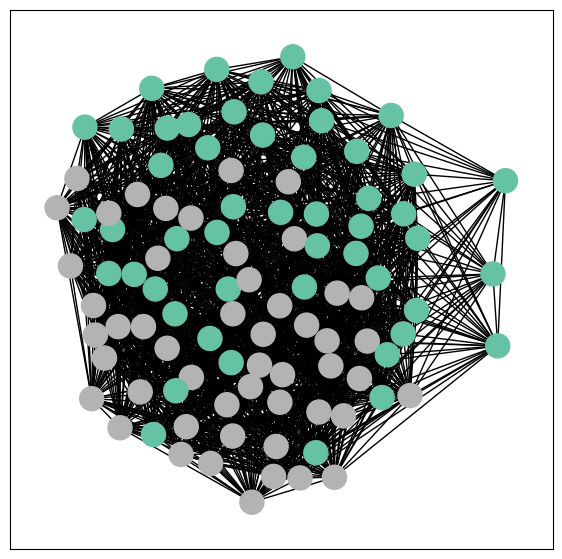

In [32]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

###GCN

In [33]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

HIDDEN_CHANNELS = 16


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN(hidden_channels=HIDDEN_CHANNELS)
print(model)

GCN(
  (conv1): GCNConv(1022, 16)
  (conv2): GCNConv(16, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


Embedding shape: [100, 2]


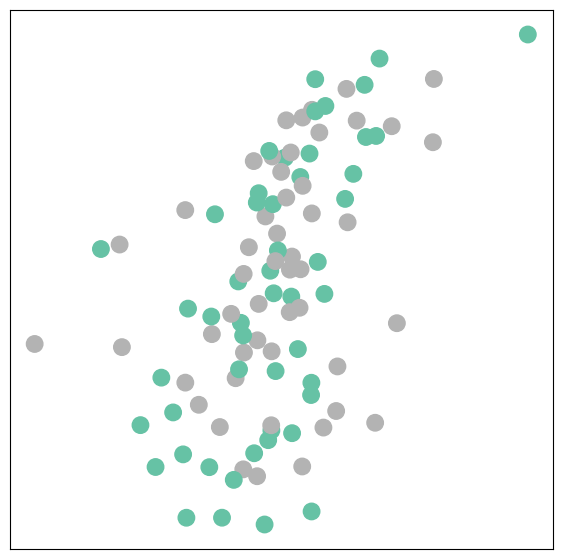

In [34]:
model = GCN(hidden_channels=HIDDEN_CHANNELS)

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=y)

In [35]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(hidden_channels=HIDDEN_CHANNELS)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 000, Loss: 0.7010
Epoch: 001, Loss: 0.6366
Epoch: 002, Loss: 0.6226
Epoch: 003, Loss: 0.6229
Epoch: 004, Loss: 0.6089
Epoch: 005, Loss: 0.6042
Epoch: 006, Loss: 0.5915
Epoch: 007, Loss: 0.5880
Epoch: 008, Loss: 0.5764
Epoch: 009, Loss: 0.5643
Epoch: 010, Loss: 0.5627
Epoch: 011, Loss: 0.5574
Epoch: 012, Loss: 0.5445
Epoch: 013, Loss: 0.5369
Epoch: 014, Loss: 0.5362
Epoch: 015, Loss: 0.5369
Epoch: 016, Loss: 0.5191
Epoch: 017, Loss: 0.5160
Epoch: 018, Loss: 0.5104
Epoch: 019, Loss: 0.5096
Epoch: 020, Loss: 0.4956
Epoch: 021, Loss: 0.4794
Epoch: 022, Loss: 0.4847
Epoch: 023, Loss: 0.4870
Epoch: 024, Loss: 0.4669
Epoch: 025, Loss: 0.4505
Epoch: 026, Loss: 0.4586
Epoch: 027, Loss: 0.4420
Epoch: 028, Loss: 0.4324
Epoch: 029, Loss: 0.4489
Epoch: 030, Loss: 0.4153
Epoch: 031, Loss: 0.3960
Epoch: 032, Loss: 0.4041
Epoch: 033, Loss: 0.3947
Epoch: 034, Loss: 0.3985
Epoch: 035, Loss: 0.3885
Epoch: 036, Loss: 0.3818
Epoch: 037, Loss: 0.3692
Epoch: 038, Loss: 0.3607
Epoch: 039, Loss: 0.3578


In [36]:
def test():
      model.eval()
      out, h = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / TEST_SAMPLES # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8500


##MLP

In [37]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=HIDDEN_CHANNELS)
print(model)

MLP(
  (lin1): Linear(in_features=1022, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [38]:
model = MLP(hidden_channels=HIDDEN_CHANNELS)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / TEST_SAMPLES  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(401):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 0.7182
Epoch: 001, Loss: 0.5280
Epoch: 002, Loss: 0.3575
Epoch: 003, Loss: 0.2176
Epoch: 004, Loss: 0.1817
Epoch: 005, Loss: 0.1052
Epoch: 006, Loss: 0.1143
Epoch: 007, Loss: 0.0818
Epoch: 008, Loss: 0.0657
Epoch: 009, Loss: 0.0612
Epoch: 010, Loss: 0.0536
Epoch: 011, Loss: 0.0595
Epoch: 012, Loss: 0.0289
Epoch: 013, Loss: 0.0064
Epoch: 014, Loss: 0.0286
Epoch: 015, Loss: 0.0286
Epoch: 016, Loss: 0.0098
Epoch: 017, Loss: 0.0216
Epoch: 018, Loss: 0.0128
Epoch: 019, Loss: 0.0409
Epoch: 020, Loss: 0.0100
Epoch: 021, Loss: 0.0316
Epoch: 022, Loss: 0.0231
Epoch: 023, Loss: 0.0173
Epoch: 024, Loss: 0.0115
Epoch: 025, Loss: 0.0108
Epoch: 026, Loss: 0.0153
Epoch: 027, Loss: 0.0140
Epoch: 028, Loss: 0.0092
Epoch: 029, Loss: 0.0190
Epoch: 030, Loss: 0.0248
Epoch: 031, Loss: 0.0024
Epoch: 032, Loss: 0.0088
Epoch: 033, Loss: 0.0258
Epoch: 034, Loss: 0.0128
Epoch: 035, Loss: 0.0167
Epoch: 036, Loss: 0.0081
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0173
Epoch: 039, Loss: 0.0228


In [39]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8500
